# Metropolis Hastings, Gibbs sampling and Autocorrelation plots

In [1]:
## Metropolis Hastings (MH) Sampling from a mixture of two 1d Gaussians
# using a 1d Gaussian proposal with different sigma.
# Author: Gerardo Duran-Martin (@gerdm)

# !pip install -qq matplotlib==3.4.2
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage() and "jax_enable_x64" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import rand, randn

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
try:
    import statsmodels.api as sm
except ModuleNotFoundError:
    %pip install -qq statsmodels
    import statsmodels.api as sm

import os
import matplotlib

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.jax.distributions as tfd
import jax
import seaborn as sns
import jax.numpy as jnp

In [2]:
def plot_gmm_3d_trace(trace_hist, π, μ, σ, title, xmin, xmax, ax, h=1, n_eval=500):
    x_eval = np.linspace(xmin, xmax, n_eval)
    kde_eval = pml.kdeg(x_eval[:, None], trace_hist[:, None], h)
    px = norm(μ, σ).pdf(x_eval[:, None]) * π
    px = px.sum(axis=-1)

    ax.plot(np.arange(n_iterations), trace_hist)
    ax.plot(np.zeros(n_eval), x_eval, px, c="tab:red", linewidth=2)
    ax.plot(np.zeros(n_eval), x_eval, kde_eval, c="tab:blue")

    ax.set_zlim(0, kde_eval.max() * 1.1)
    ax.set_xlabel("Iterations", fontsize=18)
    ax.set_ylabel("Samples", fontsize=18)
    ax.tick_params(labelsize=12)

    ax.view_init(25, -30)
    if title:
        ax.set_title(title, fontsize=18)

## Metropolis hastings

In [6]:
x0 = 20.0
tau = 8.0
probs = np.array([0.3, 0.7])
mu = np.array([-20, 20.0])
scale = np.array([10.0, 10.0])
n_iterations = 1000
xmin, xmax = -100, 100

In [7]:
def metropolis_sample_jax(x0, tau, probs, mu, scale, n_iterations, rng_key):
    x_curr = x0
    norm_mixture = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=probs), components_distribution=tfd.Normal(loc=mu, scale=scale)
    )
    x_samples = np.zeros(n_iterations)
    x_samples[0] = x_curr
    rng_keys = jax.random.split(rng_key, num=n_iterations)

    for n in range(1, n_iterations):
        x_candidate = x_curr + tau * tfd.Normal(loc=0, scale=1).sample(seed=rng_keys[n])
        p_candidate = norm_mixture.prob(x_candidate)
        p_curr = norm_mixture.prob(x_curr)
        alpha = p_candidate / p_curr
        p_accept = min(1, alpha)
        u = rand()
        x_curr = x_curr if u >= p_accept else x_candidate
        x_samples[n] = x_curr

    return x_samples

In [37]:
# os.environ["FIG_DIR"] = "figures/"
# os.environ["LATEXIFY"]= ""

In [8]:
# modification of latexify
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["backend"] = "ps"
plt.rc("text", usetex=True)

### $\tau=1$

In [9]:
%%time
tau = 1
rng_key = jax.random.PRNGKey(8)
x_samples_1 = metropolis_sample_jax(x0, tau, probs, mu, scale, n_iterations, rng_key)

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


CPU times: user 10.2 s, sys: 37.7 ms, total: 10.2 s
Wall time: 10.2 s


In [13]:
pml.is_latexify_enabled()

False

In [11]:
FIG_SIZE_TRACE = (3.6, 3) if pml.is_latexify_enabled() else None

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


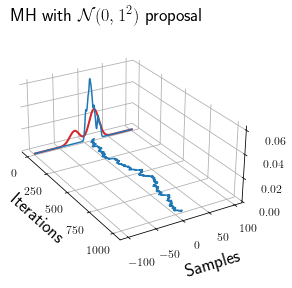

In [12]:
fig = plt.figure(figsize=FIG_SIZE_TRACE)
axs = plt.axes(projection="3d")
plot_gmm_3d_trace(
    x_samples_1, probs, mu, scale, "MH with $\mathcal{N}" + f"(0,{int(tau)}^2)$ proposal", xmin, xmax, axs
)

pml.style3d(axs, 1.5, 1, 0.8)
plt.subplots_adjust(left=0.001, bottom=0.208)
pml.savefig(f"mh_trace_{tau}tau.pdf", pad_inches=0, tight_bbox=True)

### $\tau=8$

In [14]:
%%time
tau = 8
rng_key = jax.random.PRNGKey(12)
x_samples_2 = metropolis_sample_jax(x0, tau, probs, mu, scale, n_iterations, rng_key)
# x_samples = metropolis_sample_jax_ier(x0,tau,probs,mu,scale,n_iterations,rng_key)

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


CPU times: user 9.29 s, sys: 4.43 ms, total: 9.29 s
Wall time: 9.29 s


/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


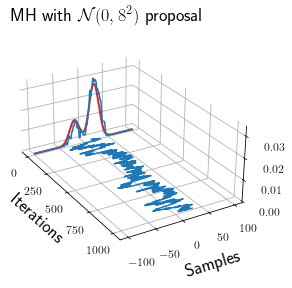

In [15]:
fig = plt.figure(figsize=FIG_SIZE_TRACE)
axs = plt.axes(projection="3d")
plot_gmm_3d_trace(
    x_samples_2, probs, mu, scale, "MH with $\mathcal{N}" + f"(0,{int(tau)}^2)$ proposal", xmin, xmax, axs
)

pml.style3d(axs, 1.5, 1, 0.8)
plt.subplots_adjust(left=0.001, bottom=0.208)
pml.savefig(f"mh_trace_{tau}tau.pdf", pad_inches=0, bbox_inches="tight")

### $\tau=500$

In [16]:
tau = 500
rng_key = jax.random.PRNGKey(10)
x_samples_3 = metropolis_sample_jax(x0, tau, probs, mu, scale, n_iterations, rng_key)

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


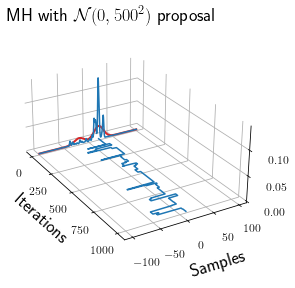

In [17]:
fig = plt.figure(figsize=FIG_SIZE_TRACE)
axs = plt.axes(projection="3d")
plot_gmm_3d_trace(
    x_samples_3, probs, mu, scale, "MH with $\mathcal{N}" + f"(0,{int(tau)}^2)$ proposal", xmin, xmax, axs
)

pml.style3d(axs, 1.5, 1, 0.8)
plt.subplots_adjust(left=0.001, bottom=0.208)
pml.savefig(f"mh_trace_{tau}tau.pdf", pad_inches=0, bbox_inches="tight")

## Gibbs sampling

In [18]:
xmin, xmax = -100, 100
x0, z0 = 20, 0
tau = 8.0
probs = np.array([0.3, 0.7])
mu = np.array([-20, 20.0])
scale = np.array([10.0, 10.0])
kv = np.arange(2)
n_iterations = 1000

In [19]:
def gibbs_sample(x0, z0, kv, probs, mu, scale, n_iterations, rng_key):
    x_curr = x0
    z_curr = z0
    z_samples = np.zeros(n_iterations)
    x_samples = np.zeros(n_iterations)
    keys = jax.random.split(rng_key, n_iterations)
    for n in range(n_iterations):
        pz = tfd.Normal(loc=mu, scale=scale).prob(x_curr) * probs
        pz = pz / pz.sum()
        z_curr = jax.random.choice(keys[n], kv, p=pz)
        x_curr = tfd.Normal(loc=mu[z_curr], scale=scale[z_curr]).sample(seed=keys[n])
        x_samples[n] = x_curr
        z_samples[n] = z_curr
    return x_samples, z_samples

In [20]:
rng_key = jax.random.PRNGKey(4)
x_samples_gibbbs, z_samples_gibbs = gibbs_sample(x0, z0, kv, probs, mu, scale, n_iterations, rng_key)

/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/patel_zeel/miniconda3/envs/py3713_2/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


In [21]:
# os.environ["FIG_DIR"] = "figures/"
# os.environ["LATEXIFY"]= ""
pml.latexify(width_scale_factor=2, fig_height=2)

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


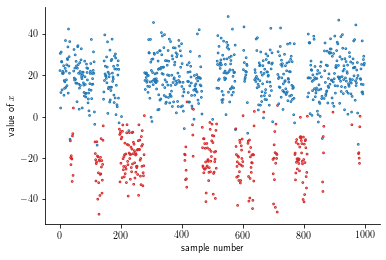

In [22]:
colors = ["tab:blue" if z else "tab:red" for z in z_samples_gibbs]
fig, axs = plt.subplots()
axs.scatter(np.arange(n_iterations), x_samples_gibbbs, s=3, facecolors="none", edgecolors=colors)
axs.set_xlabel("sample number")
axs.set_ylabel("value of $x$")
sns.despine()
pml.savefig("gibbs_scatter.pdf")

In [23]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault) # to remove laexify effect

# # modification of latexify
# plt.rcParams["pdf.fonttype"] = 42
# plt.rcParams["backend"] = "ps"
# plt.rc("text", usetex=True)

In [24]:
def plot_gmm_3d_trace_gibbs(trace_hist, π, μ, σ, title, xmin, xmax, ax, h=1, n_eval=500):
    x_eval = np.linspace(xmin, xmax, n_eval)
    kde_eval = pml.kdeg(x_eval[:, None], trace_hist[:, None], h)
    px = norm(μ, σ).pdf(x_eval[:, None]) * π
    px = px.sum(axis=-1)

    ax.plot(np.arange(n_iterations), trace_hist)
    ax.plot(np.zeros(n_eval), x_eval, px, c="tab:red", linewidth=2)
    ax.plot(np.zeros(n_eval), x_eval, kde_eval, c="tab:blue")

    ax.set_zlim(0, kde_eval.max() * 1.2)
    ax.set_xlabel("Iterations", fontsize=None)
    ax.set_ylabel("Samples", fontsize=None)
    ax.tick_params(labelsize=None)

    ax.view_init(25, -30)
    if title:
        ax.set_title(title, fontsize=None)

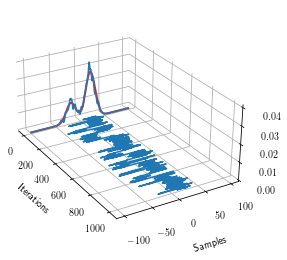

In [25]:
fig = plt.figure()
axs = plt.axes(projection="3d")
plot_gmm_3d_trace_gibbs(x_samples_gibbbs, probs, mu, scale, None, xmin, xmax, axs)
pml.style3d(axs, 1.5, 1, 0.8)
plt.subplots_adjust(left=0.001, bottom=0.208, right=0.7)
pml.savefig("gibbs_trace.pdf", tight_bbox=True, pad_inches=0)

## Autocorrelation plots

In [26]:
pml.latexify(width_scale_factor=2, fig_height=1.5)

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


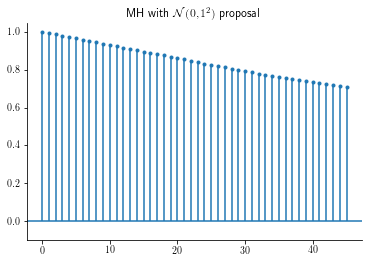

In [27]:
tau = 1
fig, ax = plt.subplots()
op = sm.graphics.tsa.plot_acf(
    x_samples_1, lags=45, alpha=None, title="MH with $\mathcal{N}" + f"(0,{int(tau)}^2)$ proposal", ax=ax, markersize=3
)
ax.set_ylim(-0.1, 1.05)
sns.despine()
pml.savefig(f"mh_autocorrelation_{tau}tau.pdf")

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


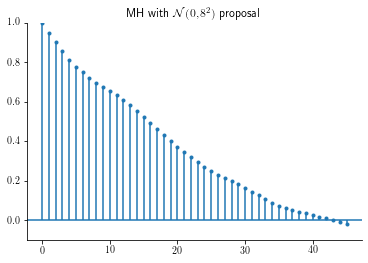

In [28]:
tau = 8
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(
    x_samples_2, lags=45, alpha=None, title="MH with $\mathcal{N}" + f"(0,{int(tau)}^2)$ proposal", ax=ax, markersize=3
)
ax.set_ylim(-0.1, 1)
sns.despine()
pml.savefig(f"mh_autocorrelation_{tau}tau.pdf")

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


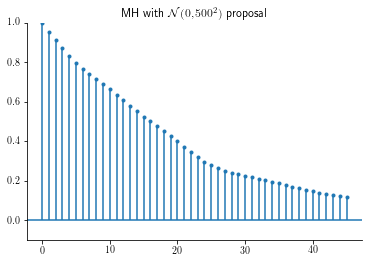

In [29]:
tau = 500
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(
    x_samples_3, lags=45, alpha=None, title="MH with $\mathcal{N}" + f"(0,{int(tau)}^2)$ proposal", ax=ax, markersize=3
)
ax.set_ylim(-0.1, 1)
sns.despine()
pml.savefig(f"mh_autocorrelation_{tau}tau.pdf")

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


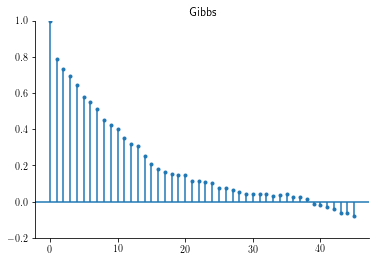

In [30]:
fig, axs = plt.subplots()
sm.graphics.tsa.plot_acf(x_samples_gibbbs, lags=45, alpha=None, title="Gibbs", ax=axs, markersize=3)
axs.set_ylim(-0.2, 1)
sns.despine()
pml.savefig("gibbs_autocorrelation.pdf")